In [1]:
using OpenQuantumTools
using LinearAlgebra
using OpenQuantumBase
using QuantumOptics
using OrdinaryDiffEq
using AVQD
using Plots
using Combinatorics
using CSV

Matrix

{Complex}

DataType

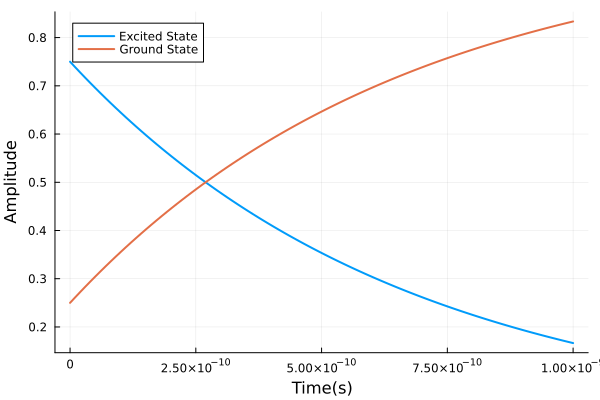

In [2]:
tf = 1000e-12
dt = 1000e-14
u0 = [1/4 1/4; 1/4 3/4]
# u0=[1/1 0;0 0]
H = Matrix{ComplexF64}(I, 2, 2)
H = Hamiltonian([(s) -> 1.0], [H], unit=:ħ)
ops = Complex[0.0 1; 0.0 0.0]
print(typeof(ops))
gamma = 1.52e9
linds = (Lindblad(gamma, ops))
print(typeof(Lindblad))

linds = InteractionSet(linds)

annealing = Annealing(H, u0, interactions=linds)
sol = solve_lindblad(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6, saveat=0:dt:tf)
excited = [Float64(sol.u[i][4]) for i in 1:100]
ground = [Float64(sol.u[i][1]) for i in 1:100]
times = LinRange(0e-12, 1000e-12, 100)
plot(times, excited, label="Excited State", xlabel="Time(s)", ylabel="Amplitude", linewidth=2)
plot!(times, ground, label="Ground State", linewidth=2)

In [25]:
function update_state_here!(A::Ansatz)
    if !isempty(A.A)
        state = A.ref |> copy
        for i in 1:length(A.A)
            print("\n State:", state)
            # print("\n aexp:",AVQD.aexp(A.A[i], A.θ[i]))
            state = AVQD.aexp(A.A[i], A.θ[i]) * state
            # print("\n later state:",state)
        end
        A.state = state
    else
        A.state = A.ref
    end
end


update_state_here! (generic function with 1 method)

In [26]:
function hereone_step!(A::Ansatz{true}, He, Ha, dt, t)
    relrcut = A.relrcut
    ψ = A |> AVQD.get_state
    dψ = AVQD.partial_theta(A)
    M = AVQD.build_m(ψ, dψ)
    V = AVQD.build_v(ψ, dψ, He, Ha)
    # print("\n M:",M)
    # print("\n V:",V)


    dθ, vmv = AVQD.lin_solve(M, V)
    # print("\n dθ:",dθ)
    # print("\n vmv:",vmv)
    #vmv = V' * inverse(M) * V
    #bound = 2 * real(ψ' * Ha * Ha * ψ + (ψ' * Ha * ψ)^2) #
    #cross = 2 * imag(ψ' * (He * Ha - Ha * He) * ψ)
    #varHe = 2 * real(ψ' * He * He * ψ - (ψ' * He * ψ)^2)

    vmvMax = vmv
    Mtmp = M
    Vtmp = V
    dθtmp = dθ
    opTmp = nothing
    dψₐTmp = nothing

    add_flag = true

    while add_flag
        tagTmp = nothing
        for op in A.pool
            if (AVQD.get_newest_A(A) |> AVQD.tag) == AVQD.tag(op)
                continue
            end
            dψₐ = -0.5im * AVQD.lmul(op, ψ)
            Mop = AVQD.update_m(M, dψₐ, ψ, dψ)
            Vop = AVQD.update_v(V, dψₐ, ψ, He, Ha)
            # print("\n Mop_trace:",tr(Mop))
            # print("\n Mop_condition0:", cond(Mop))

            dθop, vmvOp = AVQD.lin_solve(Mop, Vop)
            # print("\n dθop:", dθop)        # saurabh
            # print("\n inside 'of' for OP")

            #vmvOp = Vop' * inverse(Mop) * Vop
            if vmvOp > vmvMax
                # adding op decrease the distance
                # print("\n inside 'if' of 'of' for OP")
                Mtmp = Mop
                Vtmp = Vop
                vmvMax = vmvOp
                dθtmp = dθop
                opTmp = op
                tagTmp = AVQD.tag(op)
                dψₐTmp = dψₐ
            end
        end
        # print("\n diff:", vmvMax - vmv)
        # print("\n time: \t", t)
        # print("\n relrcut:", relrcut)
        add_flag = vmvMax - vmv < relrcut ? false : true
        if tagTmp !== nothing && add_flag
            #@info "Add operator to ansatz" tagTmp
            # print("\n tagTMP:", tagTmp)
            # print("\n A.mat:",opTmp)
            
            # aexp_here(P::PauliOperator, θ) = cos(θ / 2) * I - 1.0im * sin(θ / 2) * P.mat
            # aexp_here(opTmp,)
            # print("\n add_flag", add_flag)
            # print("\n inside adding op")

            AVQD.add_A!(A, opTmp)
            vmv = vmvMax

            #@show varHe - vmv + bound + cross
            M = Mtmp
            V = Vtmp
            dθ = dθtmp
            # updatehere_θ!(A_here::Ansatz, dθ, dt) = A_here.θ = A_here.θ + dθ * dt
            # heretheta=updatehere_θ!(A, dθ, dt)
            # print("\n heretheta:", heretheta)
            push!(dψ, dψₐTmp)
        end
    end
    #dθ = inverse(M) * V
    AVQD.update_θ!(A, dθ, dt)
    update_state_here!(A)
end

hereone_step! (generic function with 1 method)

In [27]:
function heresolve_avq(H::VectorizedEffectiveHamiltonian, A::Ansatz, tspan, dt::Number)
    # store inital ref state for reinitializtion
    ref_init = A |> AVQD.get_ref
    # print("\n here_1")

    nqbit = A.nqbit
    # reset current state
    AVQD.update_state!(A)
    # initial time
    t = tspan[1]
    # results recorder
    t_list = []
    u_list = []
    θ_list = []
    A_list = []
    norm_list = []
    push!(t_list, t)
    push!(u_list, reshape(A |> AVQD.get_state, 2^nqbit, 2^nqbit))
    push!(θ_list, A.θ |> copy)
    push!(A_list, [i |> AVQD.tag for i in A.A])
    push!(norm_list, 1.0)
    Γ = 0
    t_idx = 2
    # print("\n here_2")
    while t + dt <= tspan[2]
        # print("\n here2: \t", t)
        @debug "Solving for t:" t
        He = AVQD.herm(H, t)
        Ha = AVQD.antiherm(H)
        @debug "Current ansats:" [i |> AVQD.tag for i in A.A]
        # print("\n Current ansats:", [i |> AVQD.tag for i in A.A])
        # print("\n Current θ:", A.θ)
        # print("\n current_u",A.state)
        hereone_step!(A, He, Ha, dt, t)
        # print("\n here3_time:",t)
        ψ = A |> AVQD.get_state
        # print("\n ψ:",ψ)
        print("\n Γ:",Γ)
        Γ = Γ + 2 * real(ψ' * Ha * ψ) * dt
        ρ = reshape(ψ, 2^nqbit, 2^nqbit)
        # renormalize density matrix
        ρ = ρ / tr(ρ)

        t_idx += 1
        t += dt
        push!(t_list, t)
        push!(u_list, ρ)
        push!(θ_list, A.θ |> copy)
        push!(A_list, [i |> AVQD.tag for i in A.A])
        # record the norm shrinking
        push!(norm_list, exp(-Γ))
    end
    # print("\n Length of Final ansats:", length([i |> AVQD.tag for i in A.A]))

    # print("\n Final ansats:", [i |> AVQD.tag for i in A.A])
    # print("\n A_list:",size(A_list[101]))
    # print("\n θ_last:",A.θ)
    # print("\n θ_list:",θ_list)
    # reset ansatz to the inital condition

    AVQD.set_ref!(A, ref_init)
    AVQD.reset!(A)
    AVQD.AVQDSol(t_list, u_list, θ_list, A_list, [], [], norm=norm_list)
end


heresolve_avq (generic function with 1 method)

In [28]:
# using DataFrames

# function heresolve_avq(H::VectorizedEffectiveHamiltonian, A::Ansatz, tspan, dt::Number, output_file::AbstractString)
#     # store inital ref state for reinitializtion
#     ref_init = A |> AVQD.get_ref

#     nqbit = A.nqbit
#     AVQD.update_state!(A)
#     t = tspan[1]
#     t_list = []
#     u_list = []
#     θ_list = []
#     A_list = []
#     norm_list = []
#     push!(t_list, t)
#     push!(u_list, reshape(A |> AVQD.get_state, 2^nqbit, 2^nqbit))
#     push!(θ_list, A.θ |> copy)
#     push!(A_list, [i |> AVQD.tag for i in A.A])
#     push!(norm_list, 1.0)
#     Γ = 0
#     t_idx = 2
#     while t + dt <= tspan[2]
#         He = AVQD.herm(H, t)
#         Ha = AVQD.antiherm(H)
#         hereone_step!(A, He, Ha, dt, t)
#         ψ = A |> AVQD.get_state
#         Γ = Γ + 2 * real(ψ' * Ha * ψ) * dt
#         ρ = reshape(ψ, 2^nqbit, 2^nqbit)
#         ρ = ρ / tr(ρ)

#         t_idx += 1
#         t += dt
#         push!(t_list, t)
#         push!(u_list, ρ)
#         push!(θ_list, A.θ |> copy)
#         push!(A_list, [i |> AVQD.tag for i in A.A])
#         push!(norm_list, exp(-Γ))
#     end

#     # Write the data to a CSV file
#     # csv_data = Dict("t" => t_list, "u" => u_list, "θ" => θ_list, "A" => A_list, "norm" => norm_list)
#     # CSV.write(output_file, DataFrame(csv_data))

#     # Reset ansatz to the initial condition
#     AVQD.set_ref!(A, ref_init)
#     AVQD.reset!(A)
#     AVQD.AVQDSol(t_list, u_list, θ_list, A_list, [], [], norm=norm_list)
# end


ComplexF64[0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im -1.52e9 + 0.0im; 0.0 + 0.0im 7.6e8 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 7.6e8 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 1.52e9 + 0.0im]


 State:[0.2500000000000001, 0.4330127018922195, 0.4330127018922195, 0.7500000000000003]
 State:ComplexF64[0.2897481651720589 + 0.0im, 0.4555482840902166 + 0.0im, 0.40923802470256804 + 0.0im, 0.7355582918976754 + 0.0im]
 State:ComplexF64[0.3344087115718562 + 0.0im, 0.42953478096761694 + 0.0im, 0.43646291015285793 + 0.0im, 0.7163594165116082 + 0.0im]
 State:ComplexF64[0.34130849048158146 + 0.0im, 0.4240729050071836 + 0.0im, 0.4248258564044297 + 0.0im, 0.723321282207427 + 0.0im]
 State:ComplexF64[0.35635305975467596 + 0.0im, 0.4497896595283525 + 0.0im, 0.4122875098133016 + 0.0im, 0.7076162577533085 + 0.0im]
 State:ComplexF64[0.37630299126042827 + 0.0im, 0.43323700186341996 + 0.0im, 0.44382440928970235 + 0.0im, 0.6882744021852744 + 0.0im]
 Γ:0
 State:[0.2500000000000001, 0.4330127018922195, 0.4330127018922195, 0.7500000000000003]
 State:ComplexF64[0.31792849469626566 + 0.0im, 0.4710073803659695 + 0.0im, 0.39134645474411456 + 0.0im, 0.7238241998304333 + 0.0im]
 State:ComplexF64[0.399250474

0.4330127018922195, 0.4330127018922195, 0.7500000000000003]
 State:ComplexF64[0.3768036542227233 + 0.0im, 0.5018107979245949 + 0.0im, 0.350978522257818 + 0.0im, 0.6949956878746824 + 0.0im]
 State:ComplexF64[0.5305219283922887 + 0.0im, 0.40453647617751964 + 0.0im, 0.4597284409756213 + 0.0im, 0.5861283848227518 + 0.0im]
 State:ComplexF64[0.546234523209621 + 0.0im, 0.3830549865452161 + 0.0im, 0.4359851995455528 + 0.0im, 0.6039980370117337 + 0.0im]
 State:ComplexF64[0.5883522673383025 + 0.0im, 0.4434027410982963 + 0.0im, 0.37722255776490365 + 0.0im, 0.5611940489863559 + 0.0im]
 State:ComplexF64[0.6614448929683437 + 0.0im, 0.32443032358535845 + 0.0im, 0.47633175458998894 + 0.0im, 0.4799413279491766 + 0.0im]
 State:ComplexF64[0.6802698762059032 + 0.0im, 0.2828378984903003 + 0.0im, 0.44568988490071904 + 0.0im, 0.5085234952306338 + 0.0im]
 State:ComplexF64[0.731986530329935 + 0.0im, 0.3300586816712537 + 0.0im, 0.4119441915826216 + 0.0im, 0.4307655616345373 + 0.0im]
 State:ComplexF64[0.73198653

im, 0.4032935720125339 + 0.0im, 0.4608191562569546 + 0.0im, 0.5157559131030479 + 0.0im]
 State:ComplexF64[0.6229247237144659 + 0.0im, 0.36552199921636347 + 0.0im, 0.4280886358117803 + 0.0im, 0.5432297640620765 + 0.0im]
 State:ComplexF64[0.6783042725822193 + 0.0im, 0.44026742748059994 + 0.0im, 0.33346424894228344 + 0.0im, 0.4846333673754637 + 0.0im]
 State:ComplexF64[0.7629861097952565 + 0.0im, 0.26792590424066814 + 0.0im, 0.43832866277175986 + 0.0im, 0.3923466445492342 + 0.0im]
 State:ComplexF64[0.7857774006486563 + 0.0im, 0.1910130114246669 + 0.0im, 0.39729931227412085 + 0.0im, 0.43384462951940855 + 0.0im]
 State:ComplexF64[0.8430284197336674 + 0.0im, 0.24969742914998144 + 0.0im, 0.3632958958519891 + 0.0im, 0.3081726293075805 + 0.0im]
 State:ComplexF64[0.8430284197336674 + 0.0im, 0.24969742914998144 + 0.0im, 0.3632958958519891 + 0.0im, 0.3081726293075805 + 0.0im]
 State:ComplexF64[0.8656001004601467 + 0.0im, 0.26990289046588717 + 0.0im, 0.30564242261984476 + 0.0im, 0.2906399925967119 

[0.7500000000000003, 0.6446769614682665, 0.5520248468984612, 0.4712597014737231, 0.40080062963497887, 0.34007443236057805, 0.2879181852259814, 0.24378652058018357, 0.2062741959356347, 0.17453709937829148]
[0.2500000000000001, 0.35532303853173336, 0.4479751531015386, 0.5287402985262769, 0.599199370365021, 0.659925567639422, 0.7120818147740187, 0.7562134794198163, 0.7937258040643653, 0.8254629006217085]

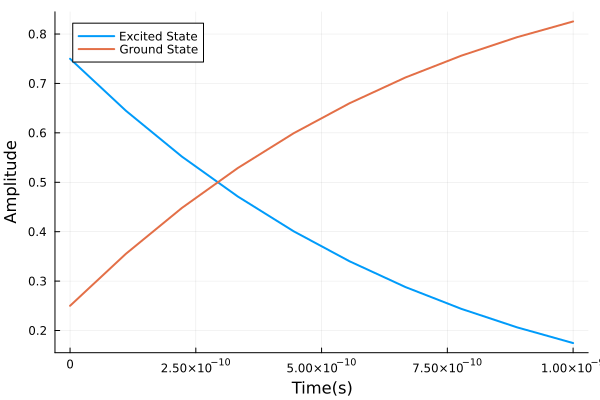

In [29]:
tf = 1000e-12
dt = 1000e-13
H = Matrix{ComplexF64}(I, 2, 2)
gamma = 1.52e9
σp = (σx + 1im * σy) / 2

linds = [AVQD.TagOperator(single_clause([σp], [i], 1.0, 1), "σ₊" * string(i), 1) for i in 1:1]
H = VectorizedEffectiveHamiltonian([(t) -> 1.0], [H], gamma, linds)
print(H.Ha)
steps=10
u0 = [1 / 2, sqrt(3) / 2] |> normalize
ansatz = Ansatz(u0, relrcut=1e-6, vectorize=true, pool="all2")
res = heresolve_avq(H, ansatz, [0, tf], dt)
excited = [Float64(res.u[i][4]) for i in 1:steps]
ground = [Float64(res.u[i][1]) for i in 1:steps]
times = LinRange(0e-12, 1000e-12, steps)
print(excited)
print("\n",ground)
plot(times, excited, label="Excited State", xlabel="Time(s)", ylabel="Amplitude", linewidth=2)
plot!(times, ground, label="Ground State", linewidth=2)

In [15]:
0.0 + 0.0im 0.0 + 0.0im 0.0 - 0.0im 0.0 - 1.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 - 1.0im 0.0 - 0.0im; 0.0 + 0.0im 0.0 + 1.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 1.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im

In [8]:
import Pkg;
Pkg.add("DataFrames");

   Resolving package versions...


    Updating `C:\Users\saura\OneDrive\Desktop\stationary_states\Project.toml`
  [a93c6f00] + DataFrames v1.6.1
    Updating `C:\Users\saura\OneDrive\Desktop\stationary_states\Manifest.toml`


  [a93c6f00] + DataFrames v1.6.1
  [41ab1584] + InvertedIndices v1.3.0
  [08abe8d2] + PrettyTables v2.3.1
  [892a3eda] + StringManipulation v0.3.4


Precompiling project...

  ✓ DataFrames
  1 dependency successfully precompiled in 48 seconds. 245 already precompiled.
